# Exercise 2: Image Recognition of Handwritten Digits

## Introduction

In this exercise, I set out to tackle the problem of handwritten digit recognition, a classic challenge in computer vision. While I can easily identify digits as a human, variations in handwriting style, thickness, and orientation often make it difficult for machines to classify them correctly. To address this, I worked with the **MNIST dataset**, which contains 70,000 grayscale images of digits (0–9), each normalised to 28×28 pixels. Of these, 60,000 are used for training and 10,000 for testing.

Before deep learning became dominant, methods such as k-nearest neighbours, SVMs, and shallow neural networks were commonly applied to MNIST. These approaches relied heavily on handcrafted features like edge detection or dimensionality reduction, which limited their ability to generalise. **Convolutional Neural Networks (CNNs)** changed this by automatically learning useful hierarchical features directly from the raw pixel values. Early layers learn simple structures such as edges and curves, while deeper layers capture more abstract representations.

In this notebook, my goals are to:
- Build and train CNN models for digit recognition.  
- Experiment with **regularisation techniques** such as dropout, early stopping, and batch normalisation to improve generalisation.  
- Explore how **hyperparameters** like learning rate, batch size, and dropout rate influence performance.  
- Evaluate my models using **accuracy, precision, recall, F1-score, and confusion matrices**.  
- Compare different CNN variants and reflect on their effectiveness and limitations.

By the end of this project, I aim to demonstrate how CNNs can achieve high performance on MNIST, while also showing what I learned about model design, tuning, and evaluation.


In [51]:
# ============================
# 1. IMPORT LIBRARIES
# ============================

# --- Numerical Operations ---
# I imported NumPy to perform efficient numerical operations and handle arrays.
import numpy as np
import pandas as pd

# --- Data Visualization ---
# I imported Matplotlib and Seaborn to plot graphs, training curves, and confusion matrices.
import matplotlib.pyplot as plt
import seaborn as sns

# --- Deep Learning ---
# I imported TensorFlow and Keras modules to build, train, and evaluate CNN models.
from tensorflow.keras import models, layers, Input
import tensorflow as tf

# --- Performance Evaluation ---
# I imported confusion_matrix and classification_report from sklearn
# to evaluate model predictions quantitatively.
from sklearn.metrics import confusion_matrix, classification_report

# --- Random Sampling ---
# I imported the random module to select random test samples for prediction visualisation.
import random


# 2. Load and Preprocess Data

To begin, I loaded the **MNIST dataset** directly from TensorFlow.  
The dataset consists of **60,000 training images** and **10,000 test images**, each a 28×28 grayscale digit (0–9).

Since raw pixel values range from 0 to 255, I normalised them to the **[0,1] range** to ensure stable and efficient training.  
I also reshaped the data to include a **channel dimension** (28×28×1), which is required as input for Convolutional Neural Networks.

After preprocessing, I confirmed the dataset shapes to verify that the images and labels were correctly formatted.


In [5]:
# ============================
# 2. LOAD AND PREPROCESS DATA
# ============================

# --- Load Dataset ---
# I loaded the MNIST dataset directly from TensorFlow, which contains 60,000 training
# images and 10,000 test images of handwritten digits (0-9) with shape (28,28).
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# --- Normalize Pixel Values ---
# I normalized the pixel values to the [0,1] range by dividing by 255,
# which helped stabilise and speed up training of the CNN models.
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# --- Reshape Data for CNN Input ---
# I added a channel dimension to the images (28,28) -> (28,28,1)
# to make them compatible with Keras Conv2D layers.
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

# --- Inspect Data Shapes ---
# I printed the shapes of the training and test sets to verify preprocessing steps.
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)


Training set shape: (60000, 28, 28, 1)
Test set shape: (10000, 28, 28, 1)


# 3. Visualize Sample Digits

To verify that the dataset had loaded correctly and to get an initial sense of its diversity,  
I visualised a few sample digits from the **training set**.  

This quick inspection confirmed that the images were 28×28 grayscale digits and highlighted the natural variation in handwriting styles, including differences in stroke thickness, tilt, and clarity.  

Such variation underscores the importance of using a model capable of learning robust features that generalise across different writing patterns.


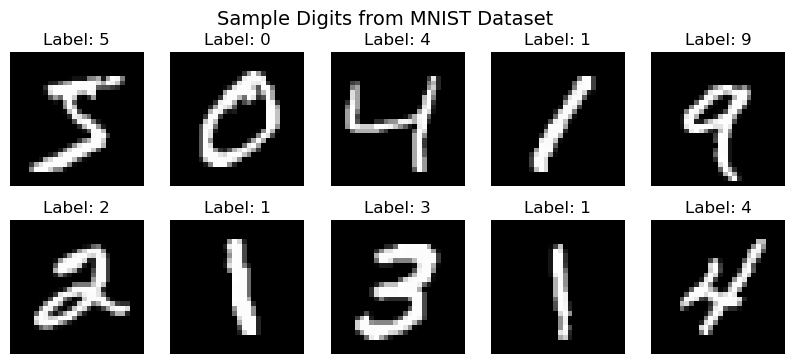

In [9]:
# ============================
# 3. VISUALIZE SAMPLE DIGITS
# ============================

# --- Purpose ---
# I visualized a selection of digits from the training set to verify that
# the dataset had loaded correctly and to gain an initial understanding
# of the diversity of handwritten digits.

# --- Create Figure ---
plt.figure(figsize=(10,4))

# --- Plot Sample Digits ---
# I plotted the first 10 training images in a 2x5 grid.
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i].squeeze(), cmap="gray")  # Removed channel dimension for display
    plt.title(f"Label: {y_train[i]}")             # Displayed the true label
    plt.axis("off")                               # Hid axes for clarity

# --- Add Title and Save Figure ---
plt.suptitle("Sample Digits from MNIST Dataset", fontsize=14)
plt.savefig("Figure 1 - sample_digits.png", dpi=300, bbox_inches="tight")  # Saved figure for report
plt.show()


# 4. Baseline CNN Model

For my first model, I built a **baseline Convolutional Neural Network (CNN)** to establish a performance benchmark.  
The architecture included two convolutional layers for feature extraction, each followed by max-pooling to reduce spatial dimensions.  
After flattening the feature maps, I added a dense hidden layer with 128 neurons and an output layer with 10 neurons (one for each digit class) using the softmax activation function.

I compiled the model with the **Adam optimiser** and **sparse categorical crossentropy loss**, tracking accuracy as the primary evaluation metric.  
Finally, I printed the model summary to verify that the architecture was correctly defined.


In [12]:
# ============================
# 4. BASELINE CNN MODEL
# ============================

# --- Purpose ---
# I built a simple baseline CNN to classify MNIST digits.
# The model served as a reference point for later improvements.

# --- Build Model ---
# I created a Sequential model with the following layers:
baseline_model = models.Sequential([
    Input(shape=(28,28,1)),               # Input layer for 28x28 grayscale images

    # First convolutional block
    layers.Conv2D(32, (3,3), activation="relu"),  # I applied 32 filters with ReLU activation to extract features
    layers.MaxPooling2D((2,2)),                  # I downsampled the feature maps to reduce dimensionality

    # Second convolutional block
    layers.Conv2D(64, (3,3), activation="relu"), # I applied 64 filters to learn more complex features
    layers.MaxPooling2D((2,2)),                  # I further downsampled the feature maps

    # Classification head
    layers.Flatten(),                             # I flattened the 2D feature maps to 1D
    layers.Dense(128, activation="relu"),        # I added a fully connected layer for high-level reasoning
    layers.Dense(10, activation="softmax")       # I used softmax activation to output probabilities for 10 classes
])

# --- Compile Model ---
# I compiled the model with the Adam optimizer for efficient gradient-based learning,
# sparse categorical crossentropy as the loss function for integer labels, 
# and accuracy as the evaluation metric.
baseline_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Inspect Architecture ---
# I printed the model summary to verify layer configurations and parameter counts.
baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Train Baseline CNN Model

I trained the **baseline CNN model** for **10 epochs**, using **20% of the training data** as a validation set to monitor performance during training.  
I set the **batch size** to 128 and tracked the **training and validation accuracy and loss** over each epoch.  

This process allowed the model to learn hierarchical features from the images through backpropagation and provided insights into its learning behaviour, including any signs of overfitting or underfitting.


In [15]:
# ============================
# 5. TRAIN BASELINE MODEL
# ============================

# --- Purpose ---
# I trained the baseline CNN to learn how to classify MNIST digits.
# I monitored performance on a validation set to check for overfitting.

# --- Train Model ---
# I trained the model for 10 epochs using a batch size of 128.
# I used 20% of the training data for validation to evaluate generalisation during training.
history_baseline = baseline_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=2  # I set verbose=2 to display per-epoch training and validation metrics
)


Epoch 1/10
375/375 - 9s - 25ms/step - accuracy: 0.9291 - loss: 0.2401 - val_accuracy: 0.9763 - val_loss: 0.0793
Epoch 2/10
375/375 - 7s - 19ms/step - accuracy: 0.9805 - loss: 0.0651 - val_accuracy: 0.9853 - val_loss: 0.0550
Epoch 3/10
375/375 - 7s - 19ms/step - accuracy: 0.9860 - loss: 0.0450 - val_accuracy: 0.9874 - val_loss: 0.0442
Epoch 4/10
375/375 - 7s - 19ms/step - accuracy: 0.9895 - loss: 0.0337 - val_accuracy: 0.9872 - val_loss: 0.0450
Epoch 5/10
375/375 - 7s - 19ms/step - accuracy: 0.9920 - loss: 0.0251 - val_accuracy: 0.9890 - val_loss: 0.0407
Epoch 6/10
375/375 - 7s - 19ms/step - accuracy: 0.9932 - loss: 0.0211 - val_accuracy: 0.9892 - val_loss: 0.0378
Epoch 7/10
375/375 - 7s - 18ms/step - accuracy: 0.9946 - loss: 0.0177 - val_accuracy: 0.9903 - val_loss: 0.0346
Epoch 8/10
375/375 - 7s - 20ms/step - accuracy: 0.9959 - loss: 0.0127 - val_accuracy: 0.9864 - val_loss: 0.0517
Epoch 9/10
375/375 - 7s - 18ms/step - accuracy: 0.9967 - loss: 0.0106 - val_accuracy: 0.9905 - val_loss:

# 6. Plot Baseline Model Performance

I plotted the **training and validation accuracy and loss** to examine how the baseline model performed over the epochs.  
The accuracy plot allowed me to see how well the model learned to classify digits on the training set versus the validation set, while the loss plot provided insight into the model’s convergence behaviour.

By comparing training and validation curves, I could identify signs of **overfitting** or **underfitting**, which would inform adjustments to the model architecture or regularisation techniques in subsequent experiments.


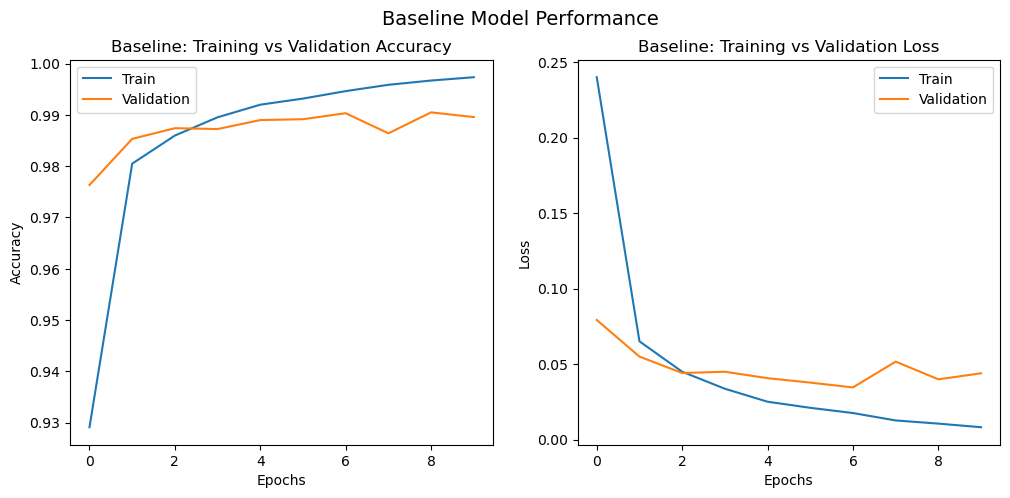

In [18]:
# ============================
# 6. PLOT BASELINE PERFORMANCE
# ============================

# --- Purpose ---
# I plotted the training and validation accuracy and loss curves
# to assess how well the baseline CNN learned and to identify any overfitting.

plt.figure(figsize=(12,5))

# --- Accuracy Curve ---
# I plotted training accuracy vs validation accuracy across epochs
# to visualise how the model's predictive performance evolved during training.
plt.subplot(1,2,1)
plt.plot(history_baseline.history["accuracy"], label="Train")       # Training accuracy per epoch
plt.plot(history_baseline.history["val_accuracy"], label="Validation")  # Validation accuracy per epoch
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.title("Baseline: Training vs Validation Accuracy")
plt.legend()

# --- Loss Curve ---
# I plotted training loss vs validation loss across epochs
# to monitor whether the model was overfitting or underfitting.
plt.subplot(1,2,2)
plt.plot(history_baseline.history["loss"], label="Train")           # Training loss per epoch
plt.plot(history_baseline.history["val_loss"], label="Validation")  # Validation loss per epoch
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("Baseline: Training vs Validation Loss")
plt.legend()

# --- Finalise Figure ---
# I added a super title for clarity and saved the figure for the report.
plt.suptitle("Baseline Model Performance", fontsize=14)
plt.savefig("Figure 2 - baseline_performance.png", dpi=300, bbox_inches="tight")
plt.show()


# 7. Improved CNN Model

I built an **improved CNN model** by adding **Dropout layers** to reduce overfitting and enhance generalisation.  
The architecture included two convolutional layers with max-pooling, each followed by a dropout layer to randomly deactivate a fraction of neurons during training.  
After flattening, I added a dense hidden layer with 128 neurons and a final dropout layer before the output layer of 10 neurons with softmax activation.

I compiled the model using the **Adam optimiser** and **sparse categorical crossentropy loss**, tracking accuracy as the primary metric.


In [21]:
# ============================
# 7. IMPROVED CNN MODEL
# ============================

# --- Purpose ---
# I built an improved CNN to enhance generalisation and reduce overfitting
# by adding Dropout layers after convolutional and dense layers.

# --- Build Model ---
improved_model = models.Sequential([
    Input(shape=(28, 28, 1)),                       # Input layer for 28x28 grayscale images

    # First convolutional block
    layers.Conv2D(32, (3,3), activation="relu"),    # I applied 32 filters to extract local features
    layers.MaxPooling2D((2,2)),                     # I downsampled feature maps to reduce dimensionality
    layers.Dropout(0.25),                           # I randomly dropped 25% of neurons to reduce overfitting

    # Second convolutional block
    layers.Conv2D(64, (3,3), activation="relu"),    # I applied 64 filters to learn more complex features
    layers.MaxPooling2D((2,2)),                     # I further downsampled feature maps
    layers.Dropout(0.25),                           # I randomly dropped 25% of neurons to improve generalisation

    # Classification head
    layers.Flatten(),                                # I flattened the 2D feature maps to 1D
    layers.Dense(128, activation="relu"),           # I added a fully connected layer for high-level feature reasoning
    layers.Dropout(0.5),                             # I applied 50% dropout to prevent overfitting in the dense layer
    layers.Dense(10, activation="softmax")          # I used softmax activation to output probabilities for 10 classes
])

# --- Compile Model ---
# I compiled the improved CNN using the Adam optimizer for efficient training,
# sparse categorical crossentropy for integer labels, and accuracy as the evaluation metric.
improved_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


# 8. Train Improved CNN Model with Early Stopping

I trained the **improved CNN model** using **early stopping** to prevent overfitting.  
The training would automatically stop if the **validation loss** did not improve for 3 consecutive epochs, and the model would **restore the best weights** observed during training.

I trained the model for up to **15 epochs** with a **batch size of 128**, using **20% of the training data** as a validation set.  
This approach allowed the model to learn efficiently while avoiding unnecessary overfitting.


In [24]:
# ============================
# 8. TRAIN IMPROVED MODEL WITH EARLY STOPPING
# ============================

# --- Purpose ---
# I trained the improved CNN while implementing EarlyStopping to prevent overfitting.
# EarlyStopping monitored the validation loss and restored the best weights if no improvement occurred.

# --- Define EarlyStopping Callback ---
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",       # I monitored validation loss to detect overfitting
    patience=3,               # I allowed 3 epochs without improvement before stopping
    restore_best_weights=True # I restored the weights from the epoch with the lowest validation loss
)

# --- Train Model ---
# I trained the improved CNN for up to 15 epochs with a batch size of 128.
# I used 20% of the training data for validation to evaluate model generalisation during training.
history = improved_model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],  # I applied EarlyStopping to halt training early if validation loss plateaued
    verbose=2                # I set verbose=2 to display per-epoch training metrics
)


Epoch 1/15
375/375 - 10s - 25ms/step - accuracy: 0.8730 - loss: 0.4023 - val_accuracy: 0.9744 - val_loss: 0.0855
Epoch 2/15
375/375 - 9s - 23ms/step - accuracy: 0.9584 - loss: 0.1396 - val_accuracy: 0.9803 - val_loss: 0.0668
Epoch 3/15
375/375 - 8s - 21ms/step - accuracy: 0.9686 - loss: 0.1039 - val_accuracy: 0.9862 - val_loss: 0.0490
Epoch 4/15
375/375 - 8s - 22ms/step - accuracy: 0.9737 - loss: 0.0872 - val_accuracy: 0.9866 - val_loss: 0.0465
Epoch 5/15
375/375 - 8s - 22ms/step - accuracy: 0.9783 - loss: 0.0739 - val_accuracy: 0.9884 - val_loss: 0.0380
Epoch 6/15
375/375 - 8s - 22ms/step - accuracy: 0.9793 - loss: 0.0701 - val_accuracy: 0.9888 - val_loss: 0.0377
Epoch 7/15
375/375 - 8s - 22ms/step - accuracy: 0.9813 - loss: 0.0617 - val_accuracy: 0.9897 - val_loss: 0.0359
Epoch 8/15
375/375 - 9s - 23ms/step - accuracy: 0.9828 - loss: 0.0550 - val_accuracy: 0.9902 - val_loss: 0.0359
Epoch 9/15
375/375 - 8s - 21ms/step - accuracy: 0.9835 - loss: 0.0546 - val_accuracy: 0.9913 - val_loss

# 9. Compare Baseline vs Improved Model

I compared the **validation accuracy** of the baseline CNN and the improved regularised CNN to evaluate the impact of **Dropout** and **early stopping**.  
Plotting both models’ validation curves allowed me to visually assess improvements in generalisation and reductions in overfitting.  

This comparison highlighted how regularisation techniques help the model maintain higher and more stable validation accuracy across epochs.


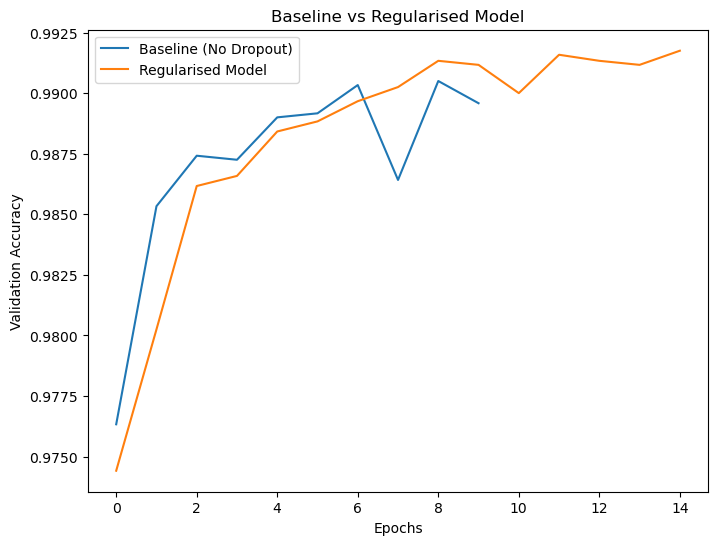

In [27]:
# ============================
# 9. COMPARE BASELINE VS IMPROVED MODEL
# ============================

# --- Purpose ---
# I compared the validation accuracy of the baseline CNN and the improved (Dropout) CNN
# to illustrate the effect of regularisation on model performance.

# --- Create Figure ---
plt.figure(figsize=(8,6))

# --- Plot Validation Accuracy ---
# I plotted the validation accuracy of the baseline model without Dropout
plt.plot(history_baseline.history["val_accuracy"], label="Baseline (No Dropout)")

# I plotted the validation accuracy of the improved model with Dropout
plt.plot(history.history["val_accuracy"], label="Regularised Model")

# --- Add Labels and Title ---
plt.xlabel("Epochs")                     # I labelled the x-axis to represent training epochs
plt.ylabel("Validation Accuracy")        # I labelled the y-axis to represent accuracy on the validation set
plt.title("Baseline vs Regularised Model") # I added a descriptive title for clarity
plt.legend()                             # I added a legend to differentiate the two models

# --- Save and Display Figure ---
plt.savefig("Figure 3 - baseline_vs_regularised.png", dpi=300, bbox_inches="tight") # I saved the figure for the report
plt.show()


# 10. Evaluate Improved CNN Model on Test Set

I evaluated the **improved CNN model** on the **unseen test set** to measure its generalisation performance.  
This final evaluation provided an unbiased estimate of how well the model can classify new handwritten digits.  

I recorded the **test accuracy** to summarise the overall effectiveness of the regularised model.


In [30]:
# ============================
# 10. EVALUATE IMPROVED MODEL ON TEST SET
# ============================

# --- Purpose ---
# I evaluated the improved CNN on the unseen test set to assess its generalisation performance
# and determine how well it could classify new, unseen digits.

# --- Evaluate Model ---
# I computed the test loss and test accuracy using the Keras evaluate() function.
test_loss, test_acc = improved_model.evaluate(x_test, y_test, verbose=0)

# --- Report Performance ---
# I printed the final test accuracy to summarise the model's generalisation capability.
print(f"Final Model Test Accuracy: {test_acc:.4f}")


Final Model Test Accuracy: 0.9919


# 11. Confusion Matrix and Classification Report

I generated predictions on the **test set** using the improved CNN model and created a **confusion matrix** to visualise how well each digit class was classified.  
This helped identify specific digits that were commonly misclassified and provided insight into patterns of errors.

Additionally, I produced a **classification report** showing **precision, recall, and F1-score** for each class, offering a more detailed evaluation of the model’s performance across all digits.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


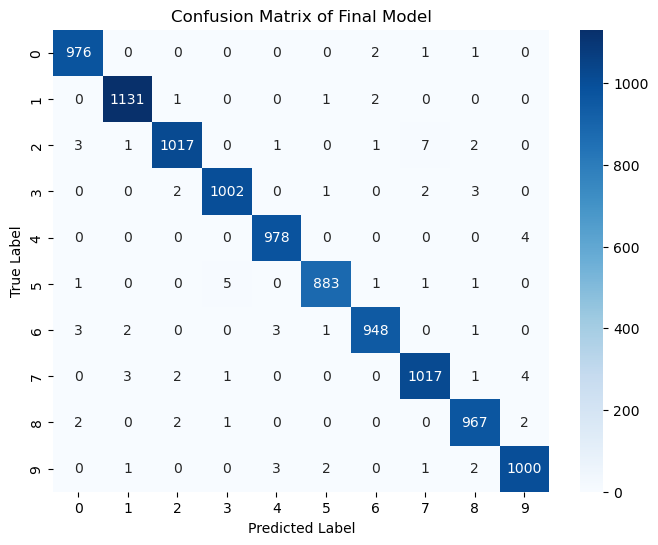

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [33]:
# ============================
# 11. CONFUSION MATRIX AND CLASSIFICATION REPORT
# ============================

# --- Purpose ---
# I generated predictions on the test set to evaluate the improved model's performance in detail.
# I plotted a confusion matrix to visualise how often each digit was correctly or incorrectly classified.
# I also produced a classification report to summarise precision, recall, and F1-score per class.

# --- Generate Predictions ---
# I used the model to predict probabilities for each class and selected the class with the highest probability.
y_pred = np.argmax(improved_model.predict(x_test), axis=-1)

# --- Compute Confusion Matrix ---
# I computed a confusion matrix to compare true labels against predicted labels.
cm = confusion_matrix(y_test, y_pred)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # I visualised counts with annotation
plt.xlabel("Predicted Label")                         # I labelled the x-axis for predicted classes
plt.ylabel("True Label")                              # I labelled the y-axis for true classes
plt.title("Confusion Matrix of Final Model")          # I added a descriptive title
plt.savefig("Figure 4 - confusion_matrix.png", dpi=300, bbox_inches="tight")  # I saved the figure for the report
plt.show()

# --- Generate Classification Report ---
# I printed a classification report to show precision, recall, and F1-score for each digit class.
print("Classification Report:\n", classification_report(y_test, y_pred))


# 12. Visualize Random Test Predictions

I visualized **25 random test images** along with their predicted labels from the improved CNN model.  
Correct predictions are highlighted in **green**, while incorrect predictions are shown in **red**.  

This visualization provided an intuitive way to inspect the model’s performance on individual samples and to see which digits were more challenging to classify correctly.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


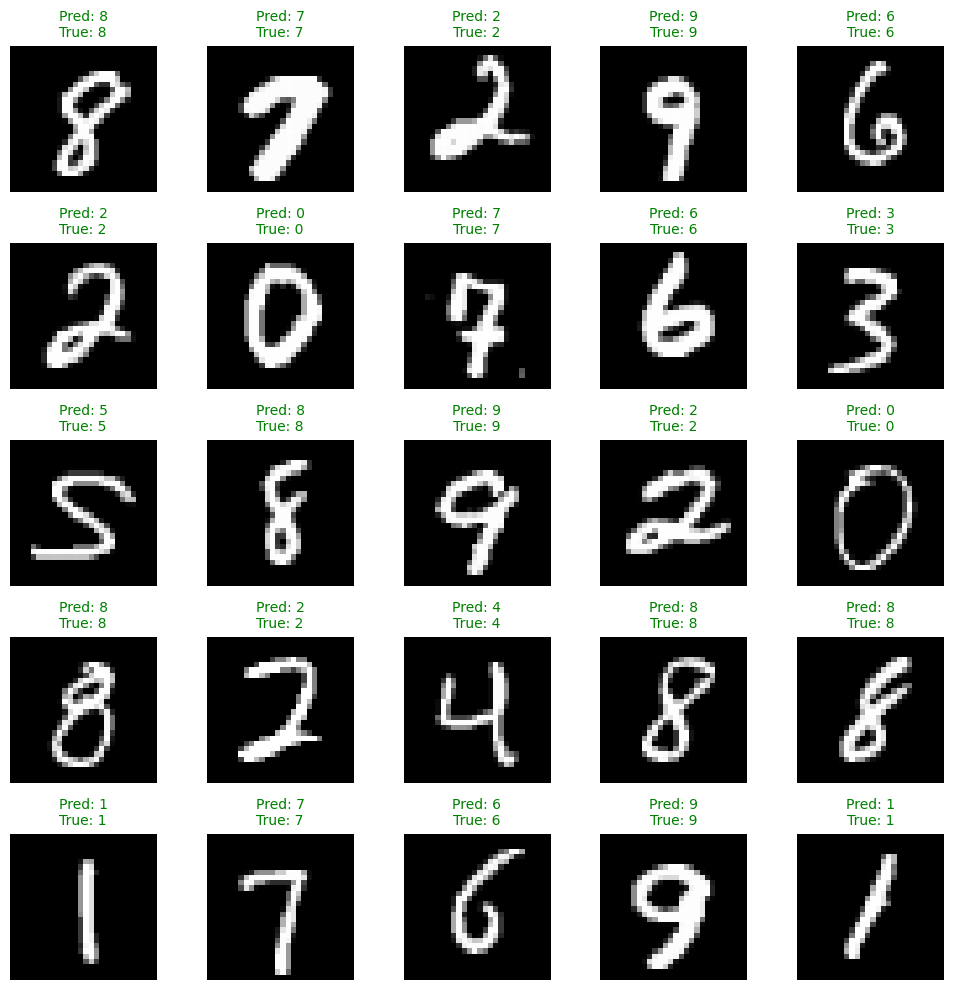

In [36]:
# ============================
# 12. VISUALIZE RANDOM TEST PREDICTIONS
# ============================

# --- Purpose ---
# I visualized a selection of random test images along with the model's predictions
# to gain a qualitative understanding of model performance.
# Correct predictions were highlighted in green and incorrect ones in red.

# --- Select Random Samples ---
# I randomly selected 25 test images and their corresponding labels for visualization.
indices = random.sample(range(len(x_test)), 25)
images = x_test[indices]
labels = y_test[indices]

# --- Generate Predictions ---
# I predicted class probabilities for the selected images and chose the class with highest probability.
pred_probs = improved_model.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)

# --- Plot Random Predictions ---
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")           # I displayed the grayscale image
    color = "green" if pred_labels[i] == labels[i] else "red"  # I set title color based on correctness
    plt.title(f"Pred: {pred_labels[i]}\nTrue: {labels[i]}", color=color, fontsize=10)
    plt.axis("off")                                        # I hid the axes for clarity

# --- Finalise Figure ---
plt.tight_layout()
plt.savefig("Figure 5 - random_test_predictions.png", dpi=300, bbox_inches="tight")  # I saved the figure for the report
plt.show()


# 13. CNN with Batch Normalisation

I built a **CNN model with Batch Normalisation (BN) layers** to improve training stability and speed up convergence.  
The architecture included two convolutional layers each followed by a **Batch Normalisation layer** and max-pooling, then a dense hidden layer with BN before the final output layer with softmax activation.

I compiled the model using the **Adam optimiser** and **sparse categorical crossentropy loss**.  
After building the model, I trained it for **10 epochs** with a **batch size of 128**, using **20% of the training data** for validation.  

This approach allowed the model to learn more robust features while reducing internal covariate shift during training.


In [39]:
# ============================
# 13. CNN WITH BATCH NORMALISATION
# ============================

# --- Purpose ---
# I built a CNN with Batch Normalisation layers to improve training stability,
# allow higher learning rates, and reduce overfitting.

# --- Define Function to Build Model ---
def build_cnn_with_bn():
    """
    I defined a function to build and compile a CNN with Batch Normalisation.
    Returns:
        model (tf.keras.Model): Compiled CNN model.
    """
    model = models.Sequential([
        Input(shape=(28,28,1)),                    # Input layer for 28x28 grayscale images

        # First convolutional block
        layers.Conv2D(32, (3,3), activation="relu"), # I applied 32 filters with ReLU to extract features
        layers.BatchNormalization(),                 # I normalised activations to stabilise learning
        layers.MaxPooling2D((2,2)),                  # I downsampled feature maps to reduce dimensionality

        # Second convolutional block
        layers.Conv2D(64, (3,3), activation="relu"), # I applied 64 filters to learn complex features
        layers.BatchNormalization(),                 # I normalised activations for stable training
        layers.MaxPooling2D((2,2)),                  # I further downsampled feature maps

        # Classification head
        layers.Flatten(),                             # I flattened feature maps to 1D
        layers.Dense(128, activation="relu"),        # I added a fully connected layer
        layers.BatchNormalization(),                 # I normalised activations to reduce overfitting
        layers.Dense(10, activation="softmax")       # I used softmax to output probabilities for 10 classes
    ])

    # --- Compile Model ---
    # I compiled the BatchNorm CNN using Adam optimizer and sparse categorical crossentropy,
    # with accuracy as the evaluation metric.
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# --- Build and Inspect Model ---
# I built the BatchNorm CNN and printed its summary to verify the architecture.
bn_model = build_cnn_with_bn()
bn_model.summary()

# --- Train Model ---
# I trained the BatchNorm CNN for 10 epochs using 20% of training data for validation.
# I used a batch size of 128 and monitored performance during training.
history_bn = bn_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=2
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,930 (882.54 KB)

 Trainable params: 225,482 (880.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
375/375 - 25s - 66ms/step - accuracy: 0.9661 - loss: 0.1158 - val_accuracy: 0.2977 - val_loss: 2.4000
Epoch 2/10
375/375 - 20s - 54ms/step - accuracy: 0.9900 - loss: 0.0348 - val_accuracy: 0.9859 - val_loss: 0.0476
Epoch 3/10
375/375 - 20s - 54ms/step - accuracy: 0.9930 - loss: 0.0229 - val_accuracy: 0.9868 - val_loss: 0.0467
Epoch 4/10
375/375 - 20s - 54ms/step - accuracy: 0.9958 - loss: 0.0150 - val_accuracy: 0.9895 - val_loss: 0.0355
Epoch 5/10
375/375 - 21s - 56ms/step - accuracy: 0.9971 - loss: 0.0101 - val_accuracy: 0.9859 - val_loss: 0.0467
Epoch 6/10
375/375 - 22s - 60ms/step - accuracy: 0.9976 - loss: 0.0081 - val_accuracy: 0.9864 - val_loss: 0.0452
Epoch 7/10
375/375 - 22s - 59ms/step - accuracy: 0.9979 - loss: 0.0074 - val_accuracy: 0.9908 - val_loss: 0.0333
Epoch 8/10
375/375 - 21s - 55ms/step - accuracy: 0.9982 - loss: 0.0056 - val_accuracy: 0.9869 - val_loss: 0.0488
Epoch 9/10
375/375 - 21s - 55ms/step - accuracy: 0.9986 - loss: 0.0047 - val_accuracy: 0.9897 - 

# 14. Evaluation of Batch Normalisation CNN

I evaluated the **Batch Normalisation CNN** on the **test set** to assess its generalisation performance.  
I recorded the **test accuracy** to summarise overall effectiveness and generated **predictions** for further analysis.

To gain detailed insights, I produced a **classification report** showing precision, recall, and F1-score for each digit class.  
I also plotted a **confusion matrix** to visualise which digits were most frequently misclassified, helping identify strengths and weaknesses of the BN-CNN model.


Test Accuracy (BN-CNN): 0.9905
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report (BN-CNN):
              precision    recall  f1-score   support

           0     0.9949    0.9939    0.9944       980
           1     0.9965    0.9965    0.9965      1135
           2     0.9828    0.9942    0.9884      1032
           3     0.9892    0.9950    0.9921      1010
           4     0.9949    0.9857    0.9903       982
           5     0.9899    0.9922    0.9910       892
           6     0.9896    0.9937    0.9917       958
           7     0.9883    0.9844    0.9864      1028
           8     0.9907    0.9887    0.9897       974
           9     0.9880    0.9802    0.9841      1009

    accuracy                         0.9905     10000
   macro avg     0.9905    0.9905    0.9905     10000
weighted avg     0.9905    0.9905    0.9905     10000



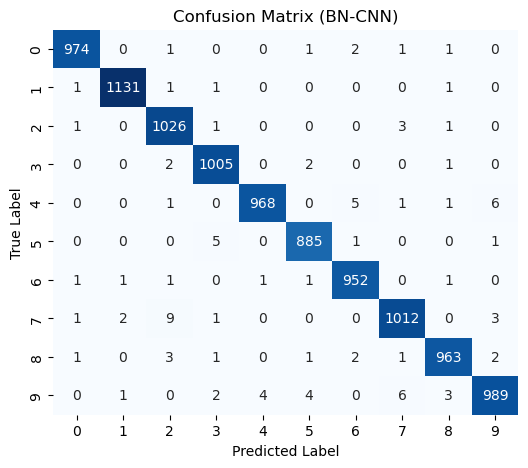

In [42]:
# ============================
# 14. EVALUATION OF BATCHNORM CNN
# ============================

# --- Purpose ---
# I evaluated the BatchNorm CNN on the test set to measure its generalisation performance.
# I generated predictions and visualised the results to understand classification behaviour.

# --- Evaluate Model ---
# I computed the test loss and test accuracy for the BatchNorm CNN.
test_loss, test_acc = bn_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy (BN-CNN): {test_acc:.4f}")

# --- Generate Predictions ---
# I predicted class labels for the test set by selecting the class with highest probability.
y_pred_bn = np.argmax(bn_model.predict(x_test), axis=1)

# --- Classification Report ---
# I printed a classification report to summarise precision, recall, and F1-score for each digit class.
print("\nClassification Report (BN-CNN):")
print(classification_report(y_test, y_pred_bn, digits=4))

# --- Confusion Matrix ---
# I computed a confusion matrix to compare true labels against predicted labels.
cm = confusion_matrix(y_test, y_pred_bn)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)  # I visualised counts with annotation
plt.xlabel("Predicted Label")                                      # I labelled x-axis for predicted classes
plt.ylabel("True Label")                                           # I labelled y-axis for true classes
plt.title("Confusion Matrix (BN-CNN)")                             # I added a descriptive title
plt.savefig("Figure 6 - bn_confusion_matrix.png", dpi=300, bbox_inches="tight")  # I saved the figure for the report
plt.show()


# 15. Training vs Validation Curves (BN-CNN)

I plotted the **training and validation accuracy and loss curves** for the Batch Normalisation CNN to analyse its learning behaviour over epochs.  
The accuracy plot shows how well the model learned to classify digits on the training set versus the validation set, while the loss plot highlights the convergence and stability of training.

These curves help identify potential **overfitting or underfitting** and provide insights into the effectiveness of Batch Normalisation in improving training dynamics.


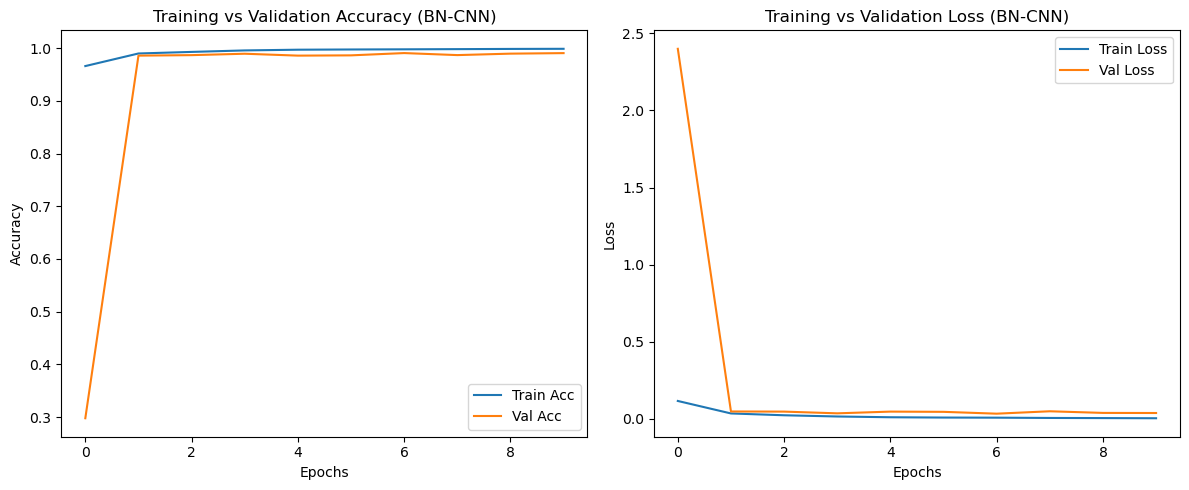

In [45]:
# ============================
# 15. TRAINING VS VALIDATION CURVES (BN-CNN)
# ============================

# --- Purpose ---
# I plotted training and validation accuracy and loss curves to evaluate
# the learning dynamics of the BatchNorm CNN and to check for overfitting or underfitting.

plt.figure(figsize=(12,5))

# --- Accuracy Curve ---
# I plotted training accuracy vs validation accuracy across epochs
# to visualise how the model's predictive performance evolved during training.
plt.subplot(1,2,1)
plt.plot(history_bn.history['accuracy'], label="Train Acc")   # I plotted training accuracy per epoch
plt.plot(history_bn.history['val_accuracy'], label="Val Acc") # I plotted validation accuracy per epoch
plt.xlabel("Epochs")                                           # I labelled the x-axis
plt.ylabel("Accuracy")                                         # I labelled the y-axis
plt.title("Training vs Validation Accuracy (BN-CNN)")         # I added a descriptive title
plt.legend()                                                   # I added a legend to differentiate curves

# --- Loss Curve ---
# I plotted training loss vs validation loss across epochs
# to monitor potential overfitting (validation loss increasing while training loss decreases).
plt.subplot(1,2,2)
plt.plot(history_bn.history['loss'], label="Train Loss")       # I plotted training loss per epoch
plt.plot(history_bn.history['val_loss'], label="Val Loss")     # I plotted validation loss per epoch
plt.xlabel("Epochs")                                           # I labelled the x-axis
plt.ylabel("Loss")                                             # I labelled the y-axis
plt.title("Training vs Validation Loss (BN-CNN)")             # I added a descriptive title
plt.legend()                                                   # I added a legend to differentiate curves

# --- Finalise Figure ---
# I adjusted layout for clarity and saved the figure for the report.
plt.tight_layout()
plt.savefig("Figure 7 - bn_training_curves.png", dpi=300, bbox_inches="tight")
plt.show()


# 16. Comparison of All Models

I compared the **test accuracies** of all three CNN models: the **Baseline CNN**, the **Dropout CNN**, and the **Batch Normalisation CNN**.  
By evaluating each model on the **unseen test set**, I was able to quantify the improvements provided by regularisation techniques like Dropout and Batch Normalisation.

I summarised the results in a **table** and saved it as a CSV file for documentation.  
This comparison highlights which architecture and regularisation strategy achieved the highest generalisation performance.


In [53]:
# ============================
# 16. COMPARISON OF ALL MODELS
# ============================

# --- Purpose ---
# I compared the test accuracies of the three CNN models (Baseline, Dropout, BatchNorm)
# to evaluate the effect of regularisation and Batch Normalisation on generalisation performance.

# --- Prepare Results Dictionary ---
# I created a dictionary to store model names and their corresponding test accuracies.
results = {
    "Model": ["Baseline CNN", "Dropout CNN", "BatchNorm CNN"],
    "Test Accuracy": []
}

# --- Collect Test Accuracies ---
# I evaluated each trained model on the unseen test set and extracted the accuracy.
baseline_acc = baseline_model.evaluate(x_test, y_test, verbose=0)[1]  # Baseline CNN
dropout_acc  = improved_model.evaluate(x_test, y_test, verbose=0)[1]   # Dropout CNN
bn_acc       = bn_model.evaluate(x_test, y_test, verbose=0)[1]         # BatchNorm CNN

# I stored the accuracies in the results dictionary.
results["Test Accuracy"] = [baseline_acc, dropout_acc, bn_acc]

# --- Create DataFrame ---
# I converted the results dictionary into a Pandas DataFrame for clear tabular presentation.

df_results = pd.DataFrame(results)
print(df_results)  # I printed the table to inspect model comparison

# --- Save Results ---
# I saved the results table as a CSV file for documentation and reporting purposes.
df_results.to_csv("Figure_model_comparison.csv", index=False)


           Model  Test Accuracy
0   Baseline CNN         0.9900
1    Dropout CNN         0.9919
2  BatchNorm CNN         0.9905


# 17. Visualise Random Test Predictions (BN-CNN)

I visualised **12 random test images** along with their predictions from the **Batch Normalisation CNN**.  
Correct predictions are shown in **green**, while incorrect predictions are highlighted in **red**.  

This visual inspection provided an intuitive way to assess the model’s performance on individual samples and to identify digits that were more challenging to classify correctly.


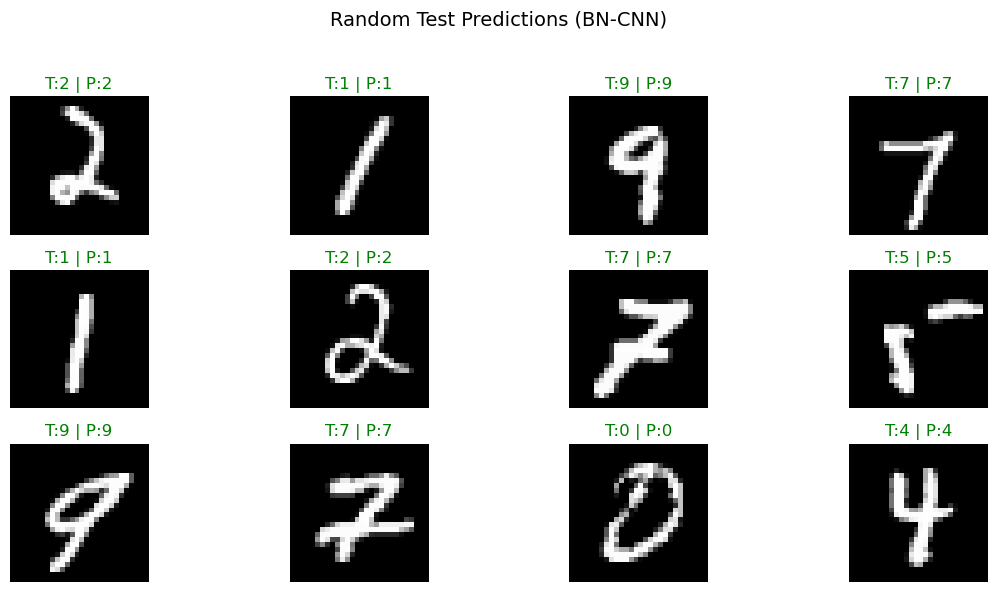

In [56]:
# ============================
# 17. VISUALISE RANDOM TEST PREDICTIONS (BN-CNN)
# ============================

# --- Purpose ---
# I visualised a selection of random test images along with the BatchNorm CNN's predictions
# to qualitatively assess the model's performance. Correct predictions were shown in green,
# and incorrect predictions in red.

# --- Select Random Samples ---
num_samples = 12
indices = random.sample(range(len(x_test)), num_samples)  # I randomly selected 12 test images

# --- Plot Random Predictions ---
plt.figure(figsize=(12,6))
for i, idx in enumerate(indices):
    plt.subplot(3,4,i+1)
    image = x_test[idx].squeeze()       # I removed the channel dimension for plotting
    true_label = y_test[idx]            # I retrieved the true label
    pred_label = y_pred_bn[idx]         # I retrieved the model's predicted label

    plt.imshow(image, cmap="gray")      # I displayed the image in grayscale
    # I set the title to show true and predicted labels; green if correct, red if incorrect
    plt.title(f"T:{true_label} | P:{pred_label}", 
              color=("green" if true_label==pred_label else "red"))
    plt.axis("off")                      # I hid the axes for clarity

# --- Finalise Figure ---
plt.suptitle("Random Test Predictions (BN-CNN)", fontsize=14)  # I added a descriptive super title
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Figure 8 - bn_random_predictions.png", dpi=300, bbox_inches="tight")  # I saved the figure for the report
plt.show()
